# Compute Distance Metrics
Compute different distance metrics for molecules

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from jcesr_ml.benchmark import load_benchmark_data
from jcesr_ml.mpnn import set_custom_objects, run_model, GraphModel
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from keras.models import load_model
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from multiprocessing import Pool
from scipy.stats import sem
from functools import partial
from util import (compute_dist_from_training_entry_mpnn, compute_sim_to_training_entry_tanimoto,
                  has_stereoisomers)
from glob import glob
from tqdm import tqdm
import pickle as pkl
import pandas as pd
import numpy as np
import json
import os

Using TensorFlow backend.
/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)

Configuration

In [2]:
set_custom_objects()
n_threads = min(32, os.cpu_count())
n_counts = [1, 2, 4, 8, 16, 32, 64]

In [3]:
with open('error-columns.json') as fp:
    err_cols = json.load(fp)

## Load in the Model and Data
We have specified the model and data to use for this test in a previous notebook. Here, we load them back in

In [4]:
model_list = list(glob(os.path.join('models', '*')))
print(f'Found {len(model_list)} models')

Found 3 models


In [5]:
models = {}
test_set = {}
convs = {}
for m in model_list:
    name = os.path.basename(m)
    test_set[name] = pd.read_csv(os.path.join('test-sets', f'{name}.csv'))
    models[name] = load_model(os.path.join(m, 'best_model.h5'))
    with open(os.path.join(m, 'converter.pkl'), 'rb') as fp:
        convs[name] = pkl.load(fp)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Ensure the list of known atom types does not change

In [6]:
for conv in convs.values():
    conv.atom_tokenizer.train = conv.bond_tokenizer.train = False

Compute total error

In [7]:
for v in test_set.values():
    v['total_error'] = v[err_cols].abs().mean(axis=1)

## Label if Molecule has Stereoisomers
Using RDKit to count the number of stereoisomers

In [8]:
with Pool(n_threads) as p:
    with_isomers = p.map(has_stereoisomers, tqdm(test_set['molecular-fingerprint']['smiles']))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 13217/13217 [06:22<00:00, 34.55it/s]


Add them to the datasets

In [9]:
for v in test_set.values():
    v['has_conformers'] = with_isomers

## Compute Distance to Training Set
We want to compute the distance of each point in the test set to the nearest entries in the training 

In [10]:
train_data, _ = load_benchmark_data()

### Tamimoto Similarity using Morgan Fingerprint
Pretty standard approach using RDKit

In [11]:
with Pool(n_threads) as p:
    func = partial(compute_sim_to_training_entry_tanimoto, train_smiles=train_data['smiles_0'].tolist(), n_nearest=n_counts)
    tanimoto_sims = p.map(func, tqdm(test_set['atomic-contribution']['smiles']))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 13217/13217 [2:02:47<00:00,  1.79it/s]


In [12]:
tan_sims = pd.DataFrame(tanimoto_sims, columns=[f'tan_sim_{k}' for k in n_counts])

Append them to the test sets

In [13]:
for k, v in test_set.items():
    test_set[k] = pd.concat([v, tan_sims], axis=1)

Plot out the error as a function of sim

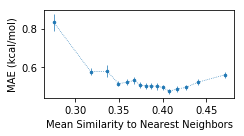

In [14]:
fig, ax = plt.subplots(figsize=(3.5, 2))

data = test_set['atomic-contribution']
n=32
dist_col = f'tan_sim_{n}'
dist_mean, dist_sem, err_mean, err_sem = zip(*[(np.mean(s[dist_col]), sem(s[dist_col]), np.mean(s['total_error']), sem(s['total_error'])) 
                                       for s in np.array_split(data.sort_values(dist_col), 16)])

ax.errorbar(dist_mean, err_mean, xerr=dist_sem, yerr=err_sem, label=f'k={n}', marker='o', markersize=2.5
            , linestyle=':', lw=0.7)
#ax.set_xscale('log', basex=10)

ax.set_xlabel('Mean Similarity to Nearest Neighbors')
ax.set_ylabel('MAE (kcal/mol)')
fig.tight_layout()

### Molecular Fingerprint from MPNN
Assess the distance based on the full molecular fingerprint

In [15]:
model = models['molecular-fingerprint']
data = test_set['molecular-fingerprint']
conv = convs['molecular-fingerprint']

In [16]:
# reduce_atom_to_mol_6 is the layer that produces the molecular fingerprint
#  I found it by printing the summary (model.summary())
rep_model = GraphModel(inputs=model.inputs, outputs=model.get_layer('reduce_atom_to_mol_6').output)

In [17]:
rep_model.save('molecule-rep-model.h5')

Compute the representations for the train and test sets

In [18]:
%%time
train_mols = run_model(rep_model, conv, train_data['smiles_0'], n_jobs=4)

CPU times: user 38min 41s, sys: 4min 48s, total: 43min 30s
Wall time: 1min 21s


In [19]:
%%time
test_mols = run_model(rep_model, conv, data['smiles'], n_jobs=4)

CPU times: user 4min 21s, sys: 31.9 s, total: 4min 53s
Wall time: 9.59 s


Compute the distance to the 64 closest neighbors

In [20]:
%%time
dim_reduction = Pipeline([
    ('scale', MinMaxScaler()),
])
nn_computer = NearestNeighbors(n_neighbors=max(n_counts), n_jobs=-1).fit(dim_reduction.fit_transform(train_mols))
train_dists = nn_computer.kneighbors(dim_reduction.transform(test_mols))[0]

CPU times: user 3h 59min 35s, sys: 15 s, total: 3h 59min 50s
Wall time: 4min 9s


In [21]:
for subset in test_set.values():
    for n in n_counts:
        subset[f'train_dist_mol_{n}'] = train_dists[:, :n].mean(axis=1)

Plot the dependence of error on distance

Text(0, 0.5, 'Mean Error (kcal/mol)')

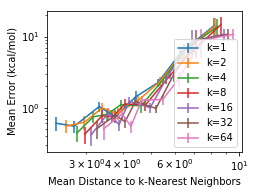

In [22]:
fig, ax = plt.subplots(figsize=(3.5, 2.6))

for n in n_counts:
    dist_col = f'train_dist_mol_{n}'
    dist_mean, err_mean, err_sem = zip(*[(np.mean(s[dist_col]), np.mean(s['total_error']), sem(s['total_error'])) 
                                           for s in np.array_split(data.query('source != "QM9"').sort_values(dist_col), 8)])

    ax.errorbar(dist_mean, err_mean, yerr=err_sem, label=f'k={n}')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('Mean Distance to k-Nearest Neighbors')
ax.set_ylabel('Mean Error (kcal/mol)')

*Finding*: The relationship between distance and error seems clearest for k=64

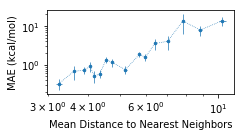

In [23]:
fig, ax = plt.subplots(figsize=(3.5, 2))

n=64
dist_col = f'train_dist_mol_{n}'
dist_mean, dist_sem, err_mean, err_sem = zip(*[(np.mean(s[dist_col]), sem(s[dist_col]), np.mean(s['total_error']), sem(s['total_error'])) 
                                       for s in np.array_split(data.query('source != "QM9"').sort_values(dist_col), 16)])

ax.errorbar(dist_mean, err_mean, xerr=dist_sem, yerr=err_sem, label=f'k={n}', marker='o', markersize=2.5
            , linestyle=':', lw=0.7)
ax.set_xscale('log', basex=10)
ax.set_yscale('log')
ax.set_xlabel('Mean Distance to Nearest Neighbors')
ax.set_ylabel('MAE (kcal/mol)')
fig.tight_layout()
fig.savefig(os.path.join('figures', 'error-vs-distance.png'), dpi=320)
fig.savefig(os.path.join('figures', 'error-vs-distance.eps'))

Drop the large arrays from memory

In [24]:
del train_dists, train_mols, test_mols

### Atomic-Level Features
We define the distance between molecules as the average distance of each atomic representation

Get the atomic representation model

In [25]:
model = models['atomic-contribution']
data = test_set['atomic-contribution']
conv = convs['atomic-contribution']

In [26]:
rep_model = GraphModel(inputs=model.inputs, outputs=model.get_layer('dense_61').input)
rep_model.output_shape

(None, 128)

In [27]:
rep_model.save('atomic-rep-model.h5')

Measure the distances for all atoms in the training set. 

The dataset of the features of all atoms is too expensive to hold in memory at once.
So, we compute features and measure distances in chunks

In [28]:
test_reps = run_model(rep_model, conv, data['smiles'], n_jobs=4)
test_reps = np.array_split(test_reps, data['n_atoms'].cumsum())[:-1]

In [29]:
train_dists_mean = np.zeros((len(test_reps), max(n_counts))) + np.inf
train_dists_max = train_dists_mean.copy()
for train_chunk in tqdm(np.array_split(train_data[['smiles_0', 'n_atom']], 8)):
    # Compute the molecular representation for this chunk
    train_reps = run_model(rep_model, conv, train_chunk['smiles_0'], n_jobs=8)
    train_reps = np.array_split(train_reps, train_chunk['n_atom'].cumsum())[:-1]
    
    # Compute the distances
    new_train_dists_mean = np.zeros((len(test_reps), len(train_chunk)))
    new_train_dists_max = new_train_dists_mean.copy()
    with Pool(n_threads) as pool:
        for i, mol_a in enumerate(test_reps):
            func = partial(compute_dist_from_training_entry_mpnn, mol_a)
            mean_dists, max_dists = zip(*pool.map(func, train_reps, chunksize=1024))
            new_train_dists_mean[i, :] = mean_dists
            new_train_dists_max[i, :] = max_dists
            
    # Sort to get the top ones
    temp = np.hstack((train_dists_mean, new_train_dists_mean))
    temp.sort(axis=1)
    train_dists_mean = temp[:, :max(n_counts)]
    
    temp = np.hstack((train_dists_max, new_train_dists_max))
    temp.sort(axis=1)
    train_dists_max = temp[:, :max(n_counts)]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [13:11:53<00:00, 5939.16s/it]


In [30]:
for subset in test_set.values():
    for n in n_counts:
        subset[f'train_dist_atom_mean_{n}'] = train_dists_mean[:, :n].mean(axis=1)
        subset[f'train_dist_atom_max_{n}'] = train_dists_max[:, :n].mean(axis=1)

As above, plot the error as a function of distance

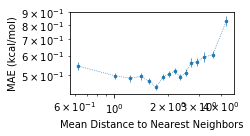

In [31]:
fig, ax = plt.subplots(figsize=(3.5, 2))

n=64
dist_col = f'train_dist_atom_mean_{n}'
dist_mean, dist_sem, err_mean, err_sem = zip(*[(np.mean(s[dist_col]), sem(s[dist_col]), np.mean(s['total_error']), sem(s['total_error'])) 
                                       for s in np.array_split(data.sort_values(dist_col), 16)])

ax.errorbar(dist_mean, err_mean, xerr=dist_sem, yerr=err_sem, label=f'k={n}', marker='o', markersize=2.5
            , linestyle=':', lw=0.7)
ax.set_xscale('log', basex=10)
ax.set_yscale('log')
ax.set_xlabel('Mean Distance to Nearest Neighbors')
ax.set_ylabel('MAE (kcal/mol)')
fig.tight_layout()

Save distances to disk

In [32]:
os.makedirs('test-sets-with-dists', exist_ok=True)
for k, subset in test_set.items():
    data.to_csv(os.path.join('test-sets-with-dists', f'{k}.csv'), index=False)